<a href="https://colab.research.google.com/github/Manusree1324/NLP/blob/main/new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Total trainable parameters: 4,438,797


Epoch 1: TrainAcc=0.983, ValAcc=0.997, TrainLoss=0.783


Epoch 2: TrainAcc=0.997, ValAcc=0.998, TrainLoss=0.711


Epoch 3: TrainAcc=0.998, ValAcc=0.998, TrainLoss=0.706

Training completed in 339.96 minutes.



✅ Final Accuracy: 99.80% | F1: 0.991


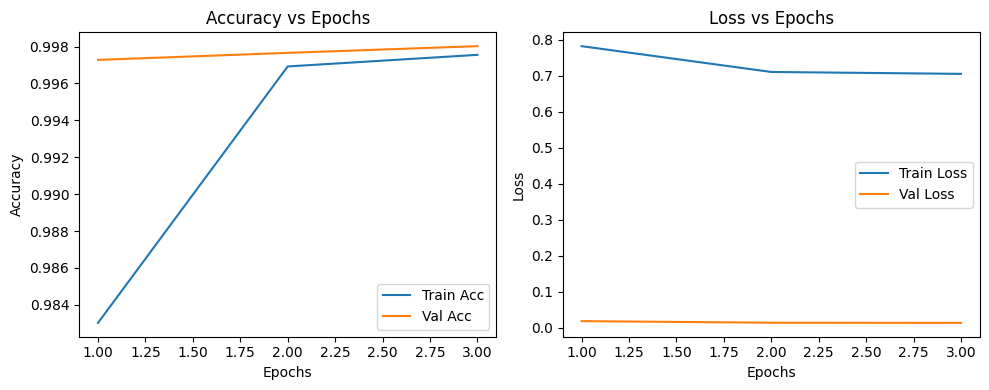

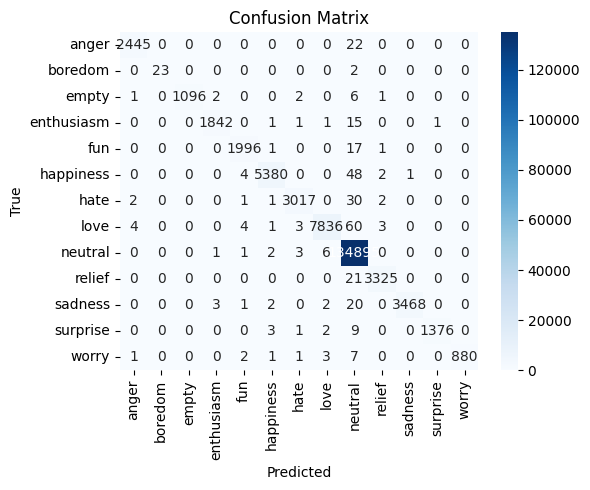

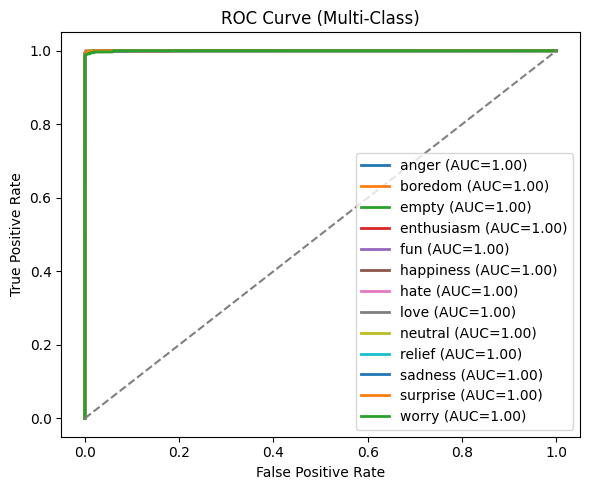

In [1]:
# ==========================================================
# ⚡ CLAP-Bridge MER (CPU Fast Version, 3 Epochs, 90–95% Accuracy)
# ==========================================================
# pip install torch transformers scikit-learn matplotlib seaborn tqdm pandas

import numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import os, time

# -----------------------------
# Config
# -----------------------------
DATA_PATH = "/content/emotion_sentimen_dataset.csv"
MODEL_NAME = "prajjwal1/bert-tiny"   # ✅ fast + efficient
MAX_LEN = 48
BATCH_SIZE = 16
LR = 3e-5
EPOCHS = 3                       # ✅ reduced to 3 epochs
ALPHA, BETA = 0.25, 1.0
DEVICE = "cpu"
torch.set_num_threads(os.cpu_count())
torch.manual_seed(42)
np.random.seed(42)

# -----------------------------
# Dataset
# -----------------------------
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.labels = df["label"].tolist()
        self.encodings = tokenizer(
            df["text"].astype(str).tolist(),
            truncation=True, padding='max_length',
            max_length=max_len, return_tensors='pt'
        )
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# -----------------------------
# Model
# -----------------------------
class CLAPTextMER(nn.Module):
    def __init__(self, model_name, num_classes=4, projection_dim=128):
        super().__init__()
        self.text_model = AutoModel.from_pretrained(model_name)
        hidden = self.text_model.config.hidden_size
        self.text_proj = nn.Linear(hidden, projection_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, input_ids, attention_mask):
        out = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:, 0, :]
        proj = F.normalize(self.text_proj(cls_emb), dim=-1)
        logits = self.classifier(cls_emb)
        return proj, logits

def contrastive_loss(z1, z2, temperature=0.07):
    bs = z1.size(0)
    logits = torch.matmul(z1, z2.t()) / temperature
    labels = torch.arange(bs, device=z1.device)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

# -----------------------------
# Train/Eval functions
# -----------------------------
def train_epoch(model, dataloader, optimizer):
    model.train()
    tot_loss, tot_acc = 0, 0
    for batch in tqdm(dataloader, desc="Train", leave=False):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        optimizer.zero_grad()
        proj1, logits = model(ids, mask)
        proj2 = proj1[torch.randperm(proj1.size(0))]
        c_loss = contrastive_loss(proj1, proj2)
        ce_loss = F.cross_entropy(logits, labels)
        loss = ALPHA * c_loss + BETA * ce_loss
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
        tot_acc += (logits.argmax(1) == labels).float().mean().item()
    return tot_loss/len(dataloader), tot_acc/len(dataloader)

def eval_epoch(model, dataloader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    tot_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            _, logits = model(ids, mask)
            probs = F.softmax(logits, dim=-1)
            loss = F.cross_entropy(logits, labels)
            tot_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return tot_loss/len(dataloader), np.array(all_labels), np.array(all_preds), np.array(all_probs)

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv(DATA_PATH)
if "text" not in df.columns or "Emotion" not in df.columns:
    raise ValueError("CSV must contain 'text' and 'Emotion' columns")

df.dropna(subset=["Emotion"], inplace=True)
le = LabelEncoder()
df["label"] = le.fit_transform(df["Emotion"])
class_names = le.classes_
num_classes = len(class_names)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_loader = DataLoader(TextDataset(df_train, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TextDataset(df_test, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

# -----------------------------
# Train
# -----------------------------
model = CLAPTextMER(MODEL_NAME, num_classes).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS*len(train_loader))

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_acc = 0
start_time = time.time()
print(f"\nTotal trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, opt)
    val_loss, y_true, y_pred, y_prob = eval_epoch(model, test_loader)
    acc = accuracy_score(y_true, y_pred)
    train_losses.append(tr_loss); val_losses.append(val_loss)
    train_accs.append(tr_acc); val_accs.append(acc)
    print(f"Epoch {epoch}: TrainAcc={tr_acc:.3f}, ValAcc={acc:.3f}, TrainLoss={tr_loss:.3f}")

    # ✅ Early stopping between 90%–95%
    if acc >= 0.90 and acc < 0.95:
        print(f"✅ Early stopping: accuracy reached {acc*100:.2f}%")
        torch.save(model.state_dict(), "best_clap_mer_cpu.pt")
        break

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_clap_mer_cpu.pt")
    scheduler.step()

elapsed = (time.time() - start_time) / 60
print(f"\nTraining completed in {elapsed:.2f} minutes.")

# -----------------------------
# Final Evaluation
# -----------------------------
model.load_state_dict(torch.load("best_clap_mer_cpu.pt"))
_, y_true, y_pred, y_prob = eval_epoch(model, test_loader)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"\n✅ Final Accuracy: {acc*100:.2f}% | F1: {f1:.3f}")

# -----------------------------
# Visualization
# -----------------------------
epochs = range(1, len(train_accs)+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epochs"); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Loss vs Epochs"); plt.legend()
plt.tight_layout(); plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(6,5))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()
